In [1]:
%load_ext autoreload 
%autoreload 2

from imports import *

seed = random.seed(10)
seed_np = np.random.seed(10)

In [2]:
graph = nx.Graph()

num_nodes = 4

# Define nodes with attributes
nodes = [0, 1, 2, 3]

# Add nodes to the graph
for node in nodes:
    graph.add_node(node)

# Define edges
edges = [(0, 1), (1, 2), (2, 3),
         (3, 0), (1, 3)
]

# Add edges to the graph
graph.add_edges_from(edges)

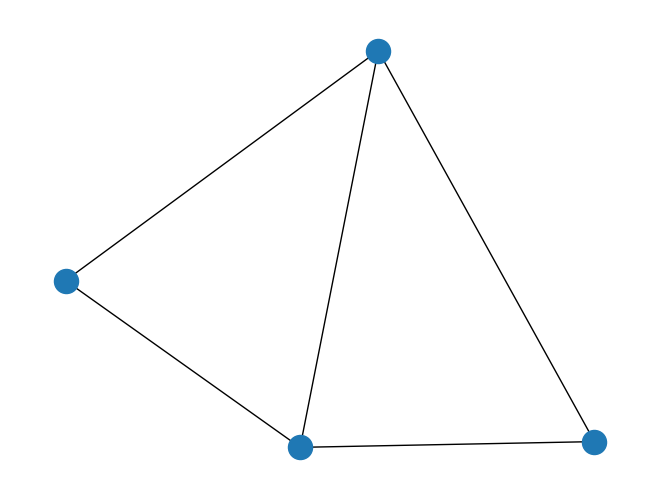

In [3]:
nx.draw(graph)

In [4]:
## Initialize the reward matrix
rewards = np.zeros((num_nodes, num_nodes))

# Assign rewards based on node urgency levels
for edge in edges:
    node1, node2 = edge
    rewards[node1, node2] = np.random.random() * 1000
    rewards[node2, node1] = rewards[node1, node2]



In [5]:
%%time
num_edges = len(graph.edges())
max_queue_length = 5
arrival_rates = np.random.rand(num_nodes)
arrival_rates = arrival_rates / np.sum(arrival_rates)
departure_rates = np.random.rand(num_nodes)
departure_rates = departure_rates / np.sum(departure_rates)

discount_factor = 0.9
learning_rate = 0.05

def symmetricize(arr1D):
    ID = np.arange(arr1D.size)
    return arr1D[np.abs(ID - ID[:,None])]

priority = symmetricize(np.array([num_edges - 1] + random.sample(range(num_edges - 1), num_edges - 1)))

# Ensure rewards are symmetric for simplicity
for i in range(num_nodes):
    for j in range(i + 1, num_nodes):
        rewards[j, i] = rewards[i, j]
        
experts = ['greedy', 'match_longest', 'match_priority']
K = len(experts)

costs_dep = np.ones(num_nodes)
costs_queue = np.ones(num_nodes)

sdm = StochasticDynamicMatching(num_nodes, graph, arrival_rates, departure_rates, rewards, priority, experts, costs_dep, costs_queue, max_queue_length=max_queue_length)

CPU times: user 551 µs, sys: 98 µs, total: 649 µs
Wall time: 219 µs


In [6]:
%%time
policy_net, critic_net, policy_collection = train_actor_critic(sdm, episodes=1000)

Training Progress: 100%|██████████████████| 1000/1000 [1:32:32<00:00,  5.55s/it]

CPU times: user 1h 55min 50s, sys: 5h 1min 26s, total: 6h 57min 16s
Wall time: 1h 32min 32s


In [7]:
num_rip_MC = 7000

In [ ]:
reward_history_collection = []
count_unif_collection = []
tau = 1
policy_count_collection = []
count = 1

for policy_net in tqdm(policy_collection):
    reward_history_collection.append([])
    policy_count_collection.append([])
    for _ in range(num_rip_MC): 
        sdm = StochasticDynamicMatching(num_nodes, graph, arrival_rates, departure_rates, rewards, priority, experts, costs_dep, costs_queue, max_queue_length=max_queue_length)
        state_history, reward_history, reward_total, policy_count = sdm.run_simulation(policy_net, discount_factor=discount_factor)
        reward_history_collection[-1].append(reward_history)
        policy_count_collection[-1].append(policy_count)
    tau = np.sqrt(1000*count)
    count += 1000

 20%|████████▏                                | 4/20 [35:39<2:25:53, 547.09s/it]

In [ ]:
reward_history_collection_1, reward_history_collection_2, reward_history_collection_3 = [], [], []

for _ in tqdm(range(num_rip_MC)):
    sdm = StochasticDynamicMatching(num_nodes, graph, arrival_rates, departure_rates, rewards, priority, experts, costs_dep, costs_queue, max_queue_length=max_queue_length)
    state_history, reward_history, reward_total = sdm.run_simulation_expert(experts[0], discount_factor=discount_factor)
    reward_history_collection_1.append(reward_history)
    
for _ in tqdm(range(num_rip_MC)):
    sdm = StochasticDynamicMatching(num_nodes, graph, arrival_rates, departure_rates, rewards, priority, experts, costs_dep, costs_queue, max_queue_length=max_queue_length)
    state_history, reward_history, reward_total = sdm.run_simulation_expert(experts[1], discount_factor=discount_factor)
    reward_history_collection_2.append(reward_history)
    
for _ in tqdm(range(num_rip_MC)):
    sdm = StochasticDynamicMatching(num_nodes, graph, arrival_rates, departure_rates, rewards, priority, experts, costs_dep, costs_queue, max_queue_length=max_queue_length)
    state_history, reward_history, reward_total = sdm.run_simulation_expert(experts[2], discount_factor=discount_factor)
    reward_history_collection_3.append(reward_history)

In [ ]:
V_1 = np.mean(np.array(reward_history_collection_1), axis=0)[-1]
V_2 = np.mean(np.array(reward_history_collection_2), axis=0)[-1]
V_3 = np.mean(np.array(reward_history_collection_3), axis=0)[-1]
V_agg = np.mean(np.array(reward_history_collection), axis=1)[:, -1]
V_agg_sdt = np.std(np.array(reward_history_collection), axis=1)[:, -1]

In [ ]:
from matplotlib.pyplot import figure

In [ ]:
# for i in range(len(V_agg)):
#     plt.plot(V_agg, color='black', linewidth=1.1, label)
figure(figsize=(10, 7))

std = 1.96 * V_agg_sdt / np.sqrt(num_rip_MC)
plt.plot(V_agg, color='black', label='agg')
plt.fill_between(np.array(range(len(V_agg))), V_agg + std, V_agg - std, alpha=0.2)
plt.hlines(V_1, 0, len(V_agg), linestyle='dashed', color='red', linewidth=1.1, label=str(experts[0]))
plt.hlines(V_2, 0, len(V_agg), linestyle='dashed', color='blue', linewidth=1.1, label=str(experts[1]))
plt.hlines(V_3, 0, len(V_agg), linestyle='dashed', color='green', linewidth=1.1, label=str(experts[2]))
plt.legend()
plt.savefig('Figures/plot_.pdf')
plt.show()